(conditional-workflow)=
# Running a conditional workflow

This example demonstrates creating a workflow that runs a function based on the result of the previous function.

In [1]:
import mlrun

## Create the project and the functions

In [2]:
project = mlrun.get_or_create_project("condition-workflow", "./", user_project=True)

> 2024-02-12 16:29:38,982 [info] Project loaded successfully: {'project_name': 'workflow-based-on-results2'}


In [3]:
%%writefile funcs.py
import time

def func_A(context, input_value):
    
    context.logger.info(f"Function A is running with input {input_value}")
    return int(input_value)

def func_B(context):
    
    context.logger.info(f"Function B is running now")        
    return "Function B has been triggered"

def func_C(context):
    
    context.logger.info(f"Function C is running now")        
    return "Function C has been triggered"


Overwriting funcs.py


In [4]:
# Set the functions in the project
func_A = project.set_function(
    func="funcs.py", name="func-A", handler="func_A", image="mlrun/mlrun", kind="job"
)
func_B = project.set_function(
    func="funcs.py", name="func-B", handler="func_B", image="mlrun/mlrun", kind="job"
)
func_C = project.set_function(
    func="funcs.py", name="func-C", handler="func_C", image="mlrun/mlrun", kind="job"
)

> 2024-02-12 16:29:39,017 [warning] Failed to add git metadata, ignore if path is not part of a git repo: {'path': './', 'error': '/User/workflows/workflow-based-on-results'}
> 2024-02-12 16:29:39,039 [warning] Failed to add git metadata, ignore if path is not part of a git repo: {'path': './', 'error': '/User/workflows/workflow-based-on-results'}
> 2024-02-12 16:29:39,064 [warning] Failed to add git metadata, ignore if path is not part of a git repo: {'path': './', 'error': '/User/workflows/workflow-based-on-results'}


Names with underscore '_' are about to be deprecated, use dashes '-' instead. Replacing 'func_A' underscores with dashes.
Names with underscore '_' are about to be deprecated, use dashes '-' instead. Replacing 'func_B' underscores with dashes.
Names with underscore '_' are about to be deprecated, use dashes '-' instead. Replacing 'func_C' underscores with dashes.


## Create the workflow

In [5]:
%%writefile workflow.py

from kfp import dsl
from mlrun.platforms import auto_mount
import os
import sys
import mlrun

@dsl.pipeline(name="Condition pipeline", description="Pipeline that runs a function based on the result of a previous function")
def kfpipeline(input_val):
    project = mlrun.get_current_project()
    
    # Run first function with the input value given to the workflow
    step_1 = mlrun.run_function('func-A', params={"input_value":str(input_val)}, returns=['first_func_res'])    

    # Based on func_A result, we run either func_B or func_C
    step_1_output = step_1.outputs["first_func_res"]
    
    with dsl.Condition(step_1_output > 5) as condition1:
        step_2 = mlrun.run_function('func-B', returns=['second_func_res'])
    condition1.after(step_1)
        
    with dsl.Condition(step_1_output <= 5) as condition2:
        step_2 = mlrun.run_function('func-C', returns=['second_func_res'])
    condition2.after(step_1)

    

Overwriting workflow.py


In [6]:
project.set_workflow(name="workflow-func", workflow_path="workflow.py")
project.save()

## Run the workflow with input_val > 5. Func_B will be triggered

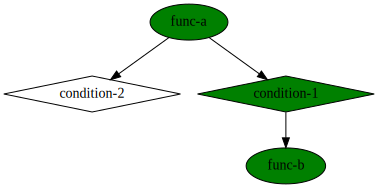

uid,start,state,name,parameters,results
...cd6094da,Feb 12 16:30:20,completed,func-b,,second_func_res=Function B has been triggered
...ed0ecc38,Feb 12 16:29:48,completed,func-a,input_value=6,first_func_res=6


6eb7fc4f-d4e5-45c6-9d18-875ed716d01c

In [7]:
project.run(
    workflow_path="workflow.py", watch=True, arguments={"input_val": 6}, local=False
)

## Run the workflow with input_val < 5. Func_C will be triggered

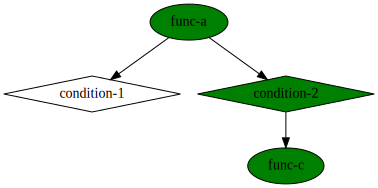

uid,start,state,name,parameters,results
...b34676e2,Feb 12 16:31:29,completed,func-c,,second_func_res=Function C has been triggered
...a71fad06,Feb 12 16:31:00,completed,func-a,input_value=3,first_func_res=3


9f1337a5-3e9c-4957-b2e1-1e73744507da

In [8]:
project.run(
    workflow_path="workflow.py", watch=True, arguments={"input_val": 3}, local=False
)